### HW recap and setup

We will train polynomial SVC in this homework.

Use the seed 0 everywhere.

1. First, generate the two moon data as follows:

"X, y = make_moons(n_samples=200, noise=0.3, random_state=0)"

Plot the data.

Randomly split the data into 80% training data and 20% testing data. Then split the training data again into 75% training data and 25% validation data. Keep this split fixed throughout the experiments.

2. For each combinations of Cs = [1E-3,1E-2,1E-1,1E0,1E1,1E2,1E3] and ds = [2,3,4]
(a) create a pipeline of polynomial features of degree d, standard scaler and linear SVC with the hyperparameter C
(b) call fit(),
(c) call predict() and measure training and validation error
Report the training and validation error for each combination.

3. Which combination has the smallest validation error? (You can manually find the minimum or you can use "i, j = np.unravel_index(np.argmin(val_errors, axis=None), val_errors.shape)" )

4. Repeat 2 with a pipeline of standard scaler and SVC with the polynomial kernel of degree d, coef0=1, and the hyperparameter C.

5. Repeat 3 with a pipeline of standard scaler and SVC .... (same as above)

6. Should the results of 3 and 5 be identical? Or if not, why? Please comment.

In [22]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### 1. First, generate the two moon data

Following instructions and stealing some more of the code

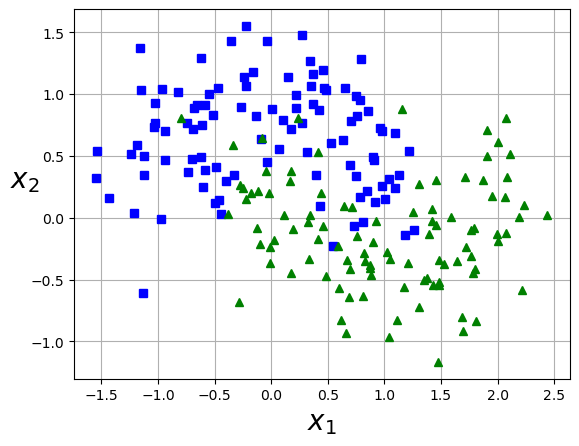

In [23]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.3, random_state=0)

def plot_dataset(X, y, axes=None):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    if axes:
        plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y)
plt.show()

### Randomly split the data into 80% training data and 20% testing data. Then split the training data again into 75% training data and 25% validation data. Keep this split fixed throughout the experiments.

Same procedure I used on the previous HW, create a permutation and then take the first 80%, then further split that range into 75% (60%) and 25% (20%) for train and validation. 

In [24]:
m = len(y)
np.random.seed(0)

# create a random index permutation
ind =np.array(range(0,m))
ind = np.random.permutation(ind)

# first 80% for train and last 20% for test 
split = int(m*0.8)
test_ind = ind[split:m]

# further split data into 75% train and 25% validation
t_split = int(m*0.6)
train_ind = ind[0:t_split]
val_ind = ind[t_split:split]

print(X[0:5])
print(X[train_ind[0:5]])

[[ 0.694565    0.42666408]
 [ 1.68353008 -0.80016643]
 [-0.25046823  0.24392224]
 [-1.13337973 -0.6112787 ]
 [ 1.76905577 -0.31025439]]
[[ 0.17916419  0.7178944 ]
 [ 0.65596964  1.05122017]
 [-0.62333307  1.28862387]
 [-1.24067726  0.51398803]
 [-0.73533716  0.36639304]]


### 2. For each combinations of Cs = [1E-3,1E-2,1E-1,1E0,1E1,1E2,1E3] and ds = [2,3,4]

#### (a) create a pipeline of polynomial features of degree d, standard scaler and linear SVC with the hyperparameter C
#### (b) call fit()
#### (c) call predict() and measure training and validation error. Report the training and validation error for each combination.

I'm once more copying and pasting the code making small ajustments. (I thing I do wonder is what does "hinge" loss means here, I read the documentation but it seems I need to know more about the svc loss function)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# to catch warnings
from sklearn.exceptions import ConvergenceWarning
import warnings 

C = [1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2]
ds = [2, 3, 4]
t_errors=[]
v_errors=[]
for c in C:
    terrors=[]
    verrors=[]
    for degrees in ds:
        # pipeline
        polynomial_svm_clf = Pipeline([
                ("poly_features", PolynomialFeatures(degree=degrees)),
                ("scaler", StandardScaler()),
                ("svm_clf", LinearSVC(C=c, loss="hinge", random_state=0))
            ])
        # fit
        with warnings.catch_warnings():  # to remove convergence warning output
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            polynomial_svm_clf.fit(X[train_ind], y[train_ind])
        # predict
        y_train = polynomial_svm_clf.predict(X[train_ind])
        y_val = polynomial_svm_clf.predict(X[val_ind])
        # find train and validation error
        terrors.append( accuracy_score(y[train_ind], y_train) )
        verrors.append( accuracy_score(y[val_ind], y_val) )
    # store errors
    t_errors.append(terrors)
    v_errors.append(verrors)


And now present the accuracy (1-errors) nicely

Text(0.5, 1.0, 'validation accuaracy')

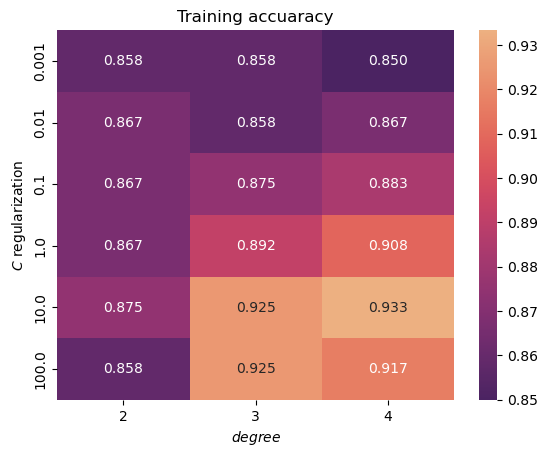

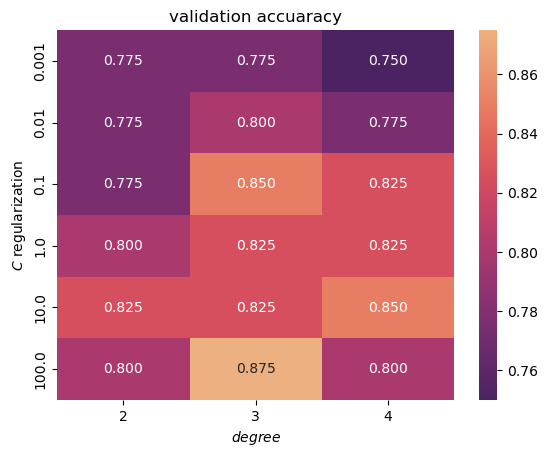

In [26]:
import seaborn as sns

# Training error
t_errors = np.array(t_errors)
sns.heatmap(
    t_errors,
    xticklabels=ds,
    yticklabels=C,
    cmap="flare_r",
    annot=True,
    fmt=".3f"
    )

plt.xlabel(r"$degree$")
plt.ylabel(r"$C$ regularization")
plt.title("Training accuaracy")

# Validation error
v_errors = np.array(v_errors)
plt.figure()
sns.heatmap(
    v_errors,
    xticklabels=ds,
    yticklabels=C,
    cmap="flare_r",
    annot=True,
    fmt=".3f"
    )

plt.xlabel(r"$degree$")
plt.ylabel(r"$C$ regularization")
plt.title("validation accuaracy")

### 3. Which combination has the smallest validation error?

Since this is a classification problem, the smallest error will correspond to the largest accuracy

In [27]:
max_ind = np.argmax(t_errors)
t_i, t_j = (max_ind // 3 , max_ind % 3)
print("training max at: ", t_i, t_j," val of: ", t_errors[t_i][t_j])

max_ind = np.argmax(v_errors)
v_i, v_j = (max_ind // 3 , max_ind % 3)
print("validation max at: ", v_i, v_j," val of: ", v_errors[v_i][v_j])

training max at:  4 2  val of:  0.9333333333333333
validation max at:  5 1  val of:  0.875


We can see that the smallest validation is obtained when $C=100$ and the degree is $3$.

### 4. Repeat 2 with a pipeline of standard scaler and SVC with the polynomial kernel of degree d, coef0=1, and the hyperparameter C.

Okay, so now let's do the same but for the SVC with polynomial kernel

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# to catch warnings
from sklearn.exceptions import ConvergenceWarning
import warnings 

C = [1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2]
ds = [2, 3, 4]
t_errors=[]
v_errors=[]
for c in C:
    terrors=[]
    verrors=[]
    for degrees in ds:
        # pipeline
        polynomial_svm_clf = Pipeline([
                ("scaler", StandardScaler()),
                ("svm_clf", SVC(kernel="poly", degree=degrees, coef0=1, C=c, random_state=0))
            ])
        # fit
        with warnings.catch_warnings():  # to remove convergence warning output
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            polynomial_svm_clf.fit(X[train_ind], y[train_ind])
        # predict
        y_train = polynomial_svm_clf.predict(X[train_ind])
        y_val = polynomial_svm_clf.predict(X[val_ind])
        # find train and validation error
        terrors.append( accuracy_score(y[train_ind], y_train) )
        verrors.append( accuracy_score(y[val_ind], y_val) )
    # store errors
    t_errors.append(terrors)
    v_errors.append(verrors)

Accuaracy again

Text(0.5, 1.0, 'validation accuaracy')

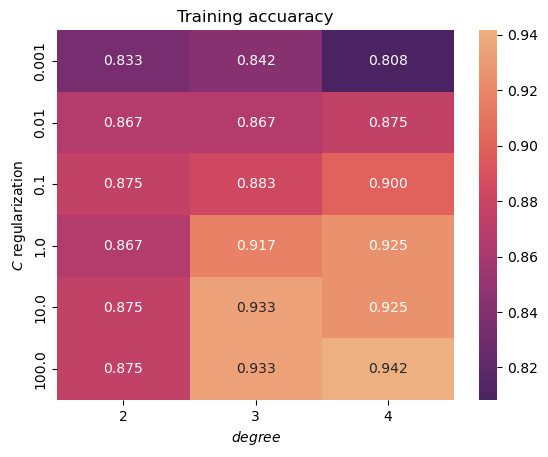

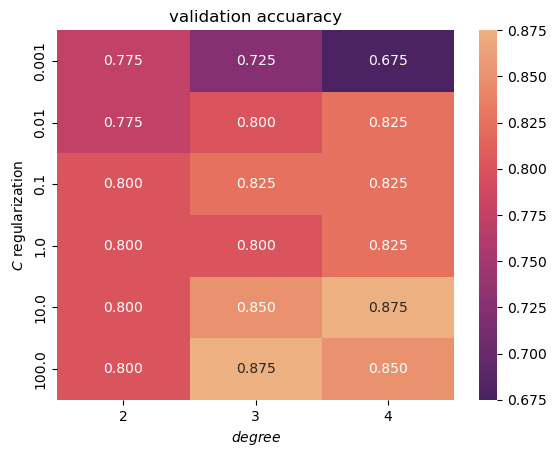

In [29]:
import seaborn as sns

# Training error
t_errors = np.array(t_errors)
sns.heatmap(
    t_errors,
    xticklabels=ds,
    yticklabels=C,
    cmap="flare_r",
    annot=True,
    fmt=".3f"
    )

plt.xlabel(r"$degree$")
plt.ylabel(r"$C$ regularization")
plt.title("Training accuaracy")

# Validation error
v_errors = np.array(v_errors)
plt.figure()
sns.heatmap(
    v_errors,
    xticklabels=ds,
    yticklabels=C,
    cmap="flare_r",
    annot=True,
    fmt=".3f"
    )

plt.xlabel(r"$degree$")
plt.ylabel(r"$C$ regularization")
plt.title("validation accuaracy")

### 5. Repeat 3 with a pipeline of standard scaler and SVC .... (same as above)

We do the same

In [30]:
max_ind = np.argmax(t_errors)
t_i, t_j = (max_ind // 3 , max_ind % 3)
print("training max at: ", t_i, t_j," val of: ", t_errors[t_i][t_j])

max_ind = np.argmax(v_errors)
v_i, v_j = (max_ind // 3 , max_ind % 3)
print("validation max at: ", v_i, v_j," val of: ", v_errors[v_i][v_j])

training max at:  5 2  val of:  0.9416666666666667
validation max at:  4 2  val of:  0.875


but get slighly different results from before if we look at the matrices. A maximum happens now at $C=10$, degree $4$ and another at $C=100$, degree $3$. 

### 6. Should the results of 3 and 5 be identical? Or if not, why? Please comment.

They should have had I not done some mistake XD. I'm pretty sure the problem lies on either the choice of the "hinge" function or on the selection of parameters somewhere... but they are at least similar and actually match in.

As for the reasons why, we saw in class that the addition of polynomial features into a space where there's an inner product that can be represented as a special (positive definite and symmetrical) function evaluating it's components which corresponds to the norm of the error function (the cost function), namely $K(a,b)=\langle \phi(a),\phi(b)\rangle$ is equivalent as using this inner product in the cost function avoiding the addition of the polynomial features.